### Required data

This notebooks assumes the presence of genomes in the `genomes` folder and the presence of annotations (external and JGI's) in the `annotation/external` and `annotation/jgi` folders. The rest of the data is generated from these files.

TODO: Download the above-mentioned files from figshare or similar.

### Common data prep

Extract idenditifers

In [6]:
ls genomes | cut -f1 -d. > list

Prepare proteins

In [15]:
%%bash
mkdir -p peptides/{jgi,external}
cat list | xargs -I {} bash -c 'gffread -y peptides/jgi/{}.primaryTrs.fa . -g genomes/{}*.fasta annotation/jgi/{}*.gff3'
cat list | xargs -I {} bash -c 'gffread -y peptides/external/{}.primaryTrs.fa . -g genomes/{}*.fasta annotation/external/{}*.gff3'

#### GENESPACE runs

1. Genespace data preparation

In [43]:
%%bash
mkdir -p genespace/{external,jgi}

cd genespace/jgi
mkdir -p gs/{peptide,bed}
cat ../../list | xargs -I {} bash -c 'tr < ../../peptides/jgi/{}.primaryTrs.fa ":" "_" > gs/peptide/{}.fa'
cat ../../list | xargs -I {} bash -c 'gffread ../../annotation/jgi/{}.primaryTrs.gff3 -T |  grep CDS | gffread | grep transcript | cut -f1,4,5,9 | sed "s/ID=//" | cut -f1 -d ";" | sed "s/:/_/g" > gs/bed/{}.bed'

cd ../external
mkdir -p gs/{peptide,bed}
cat ../../list | xargs -I {} bash -c 'tr < ../../peptides/external/{}.primaryTrs.fa ":" "_" > gs/peptide/{}.fa'
cat ../../list | xargs -I {} bash -c 'gffread ../../annotation/external/{}.primaryTrs.gff3 -T |  grep CDS | gffread | grep transcript | cut -f1,4,5,9 | sed "s/ID=//" | cut -f1 -d ";" | sed "s/:/_/g" > gs/bed/{}.bed'


2. GENESPACE is run through its [Docker container](https://hub.docker.com/layers/doejgi/genespace/latest/images/sha256-064a3cc98a063e001219ced78ab75ea3ed7fa2f678dcc64aade987c37ae231e6). The following commands use Apptainer to execute the GENESPACE script.

In [ ]:
%%bash
cd genespace/jgi
apptainer exec -B ${PWD}:${PWD} docker://doejgi/genespace@sha256:064a3cc98a063e001219ced78ab75ea3ed7fa2f678dcc64aade987c37ae231e6 Rscript ../../../scripts/run_genespace.R 
cd ../external
apptainer exec -B ${PWD}:${PWD} docker://doejgi/genespace@sha256:064a3cc98a063e001219ced78ab75ea3ed7fa2f678dcc64aade987c37ae231e6 Rscript ../../../scripts/run_genespace.R 

### Pangenome expansion

In [ ]:
%%bash
mkdir pangenomeExpansion
../scripts/computePanExpansionDiamond.py peptides/jgi pangenomeExpansion/jgi_70.tsv --identity 70 --coverage 70 --threads 16
../scripts/computePanExpansionDiamond.py peptides/external pangenomeExpansion/external_70.tsv --identity 70 --coverage 70 --threads 16

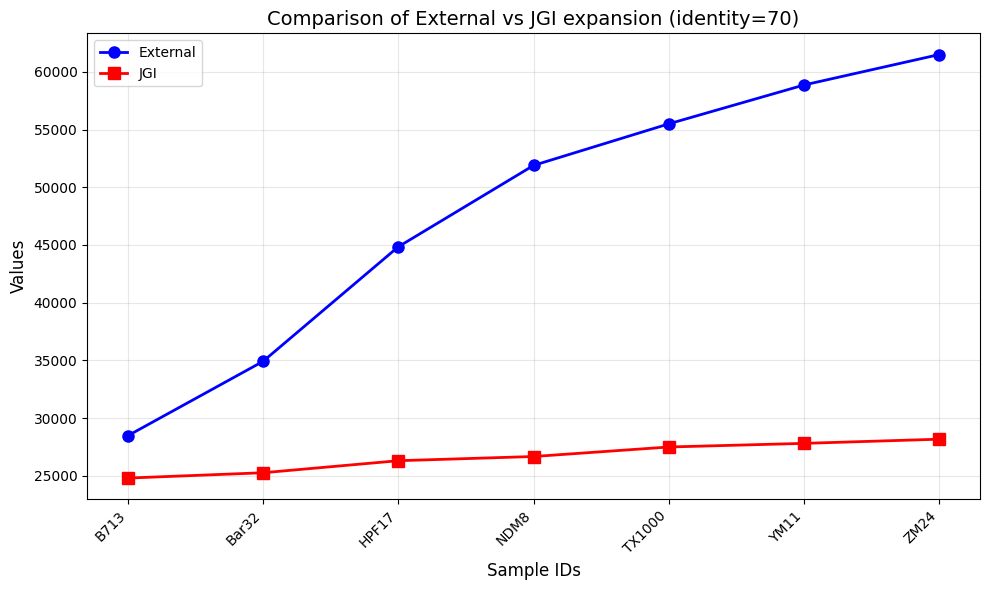

In [25]:
import matplotlib.pyplot as plt
import numpy as np

def parse_file(filename):
    with open(filename, 'r') as f:
        lines = f.readlines()
    
    identity = lines[0].strip().split('=')[1]
    
    ids = []
    values = []
    
    for line in lines[1:-1]:
        parts = line.strip().split()
        if len(parts) >= 2:
            ids.append(parts[0].replace('.primaryTrs', ''))
            values.append(int(parts[1]))
    
    return identity, ids, values

identity1, ids1, values1 = parse_file('pangenomeExpansion/external_70.tsv')
identity2, ids2, values2 = parse_file('pangenomeExpansion/jgi_70.tsv')

fig, ax = plt.subplots(figsize=(10, 6))

x_positions = np.arange(len(ids1))
ax.plot(x_positions, values1, 'b-o', label='External', markersize=8, linewidth=2)
ax.plot(x_positions, values2, 'r-s', label='JGI', markersize=8, linewidth=2)

ax.set_xticks(x_positions)
ax.set_xticklabels(ids1, rotation=45, ha='right')

ax.set_xlabel('Sample IDs', fontsize=12)
ax.set_ylabel('Values', fontsize=12)
ax.set_title(f'Comparison of External vs JGI expansion (identity={identity1})', fontsize=14)

ax.grid(True, alpha=0.3)
ax.legend()

plt.tight_layout()
plt.show()

### PAV estimate with get_homologues-est

Prepare the transcripts

In [28]:
%%bash
mkdir -p pav_estimate/{jgi/ests,external/ests}
cat list | xargs -I {} bash -c 'gffread -x pav_estimate/jgi/ests/{}.primaryTrs.fa . -g genomes/{}*.fasta annotation/jgi/{}*.gff3'
cat list | xargs -I {} bash -c 'gffread -x pav_estimate/external/ests/{}.primaryTrs.fa . -g genomes/{}*.fasta annotation/external/{}*.gff3'

To obtain `get_homologoues-est` results, execute the following commands in both folders (`pav_estimate/jgi` and `pav_estimate/external`). The expected runtime is several hours.

```bash
apptainer exec -B ${PWD}:${PWD} docker://csicunam/get_homologues:20230108 get_homologues-est.pl -d ests -n 64 -M -t 0
apptainer exec -B ${PWD}:${PWD} docker://csicunam/get_homologues:20230108 compare_clusters.pl -d ests_est_homologues/*_0taxa_algOMCL_e0_/ -o clusters_out -n -m
apptainer exec -B ${PWD}:${PWD} docker://csicunam/get_homologues:20230108 parse_pangenome_matrix.pl -m clusters_out/pangenome_matrix_t0.tab -s
```

The PAV visualization script is a modified version of https://github.com/eead-csic-compbio/get_homologues/blob/97653341c027c2c4491a85369c7aa8af8045e146/parse_pangenome_matrix.pl

In [ ]:
%%bash
y=41000
../scripts/parse_pangenome_matrix.pl -m pav_estimate/external/clusters_out/pangenome_matrix_t0.tab  -s -y $y
../scripts/parse_pangenome_matrix.pl -m pav_estimate/jgi/clusters_out/pangenome_matrix_t0.tab  -s -y $y

#### Restulting PAV estimate figures (external and JGI)

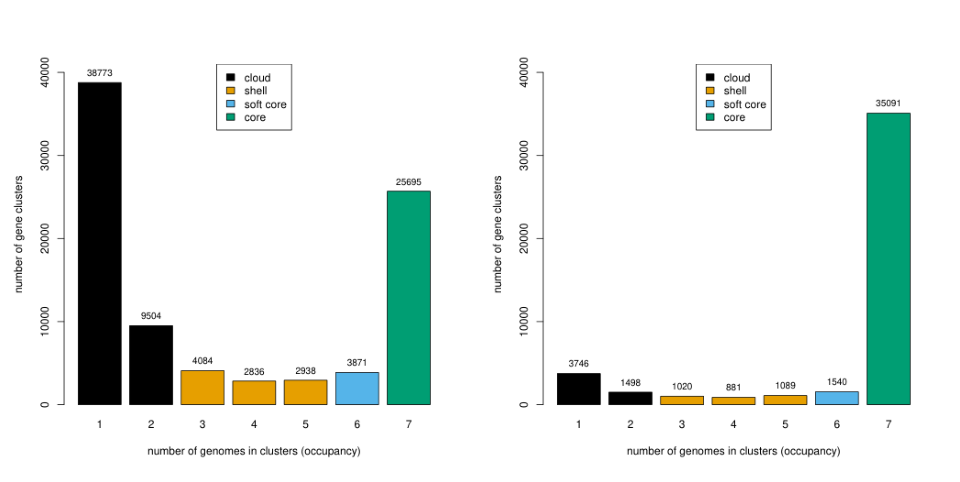

In [37]:
import fitz
from IPython.display import display, Image
import matplotlib.pyplot as plt
import io

plt.figure(figsize=(15, 6))
plt.subplot(121); plt.imshow(plt.imread(io.BytesIO(fitz.open("pav_estimate/external/clusters_out/pangenome_matrix_t0__shell.pdf")[0].get_pixmap().tobytes("png")))); plt.axis('off')
plt.subplot(122); plt.imshow(plt.imread(io.BytesIO(fitz.open("pav_estimate/jgi/clusters_out/pangenome_matrix_t0__shell.pdf")[0].get_pixmap().tobytes("png")))); plt.axis('off')
plt.subplots_adjust(wspace=-0.3)


### Annotation Consistency Evaluation

#### Data preparation

1. We want to compare only the protein coding predictions. Prepare a gff3s with just coding regions:

In [ ]:
%%bash
cd annotation/jgi; mkdir coding_regions; ls *.gff3  |  xargs -I {} bash -c 'gffread -T {} | grep -P "\tCDS\t"| gffread --keep-genes | sed "s/\ttranscript\t/\tmRNA\t/" > coding_regions/{}'; cd ../..
cd annotation/external; mkdir coding_regions; ls *.gff3  |  xargs -I {} bash -c 'gffread -T {} | grep -P "\tCDS\t"| gffread --keep-genes | sed "s/\ttranscript\t/\tmRNA\t/" > coding_regions/{}'

2. Run a WDL workflow that lifts genes between all pairs of annotations/genomes with Liftoff.
* Prepare inputs for the worklow:

In [10]:
%%bash
mkdir -p consistency/{jgi,external}/liftoff
cd consistency/jgi/liftoff
cat ../../../list  | xargs -I {} bash -c 'echo -en "../../../genomes/{}.genome.fasta\t../../../annotation/jgi/coding_regions/{}.primaryTrs.gff3\n"' > pairs.tsv
../../../../scripts/WDL/tsvToJsonInput.py pairs.tsv > input.json
cd ../../external/liftoff
cat ../../../list  | xargs -I {} bash -c 'echo -en "../../../genomes/{}.genome.fasta\t../../../annotation/external/coding_regions/{}.primaryTrs.gff3\n"' > pairs.tsv
../../../../scripts/WDL/tsvToJsonInput.py pairs.tsv > input.json

- b. Run the WDL workflow `/scripts/WDL/liftAll.wdl` with the `input.json` for both external and jgi annotations and copy all pairwise comparsions (the `$ID.genome.fasta_to_$ID.genome.fasta.gff3` files) to a `results` folder in `consistency/{jgi,external}/liftoff/results`

#### Annotation Consistency Visualition

In [ ]:
%%bash
cd consistency/jgi;
../../../scripts/visualize_pairwise_consistency.py ../../annotation/jgi/coding_regions/ liftoff/results gffCompare  --mappingThreshold 1  --save-csv
cd ../external
../../../scripts/visualize_pairwise_consistency.py ../../annotation/external/coding_regions/ liftoff/results gffCompare  --mappingThreshold 1  --save-csv

#### Consistency of perfect matches

(np.float64(-0.5), np.float64(689.5), np.float64(603.5), np.float64(-0.5))

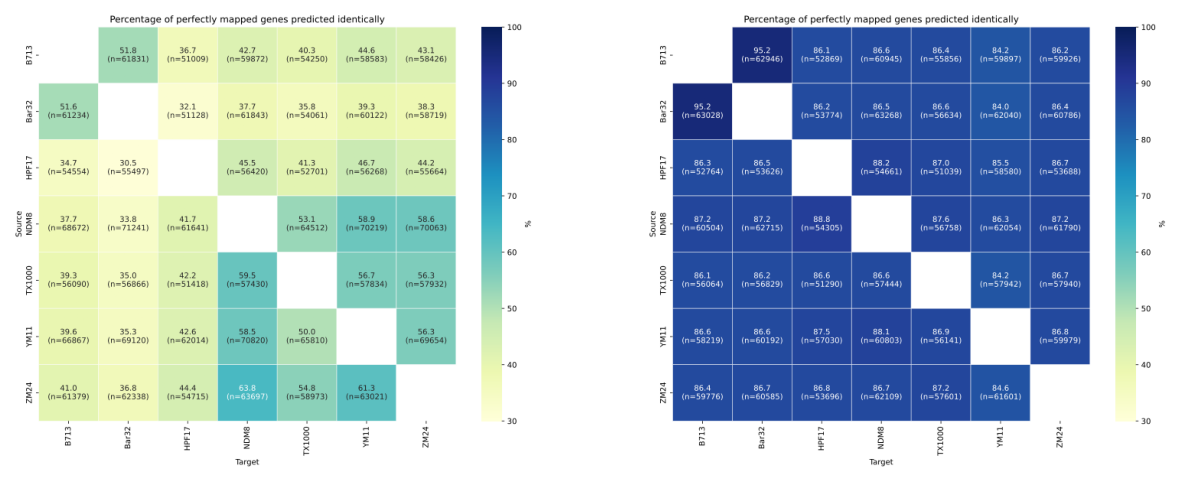

In [24]:
import fitz
from IPython.display import display, Image
import matplotlib.pyplot as plt
import io

plt.figure(figsize=(15, 6))
plt.subplot(121); plt.imshow(plt.imread(io.BytesIO(fitz.open("consistency/external/gene_identity_1.0.pdf")[0].get_pixmap().tobytes("png")))); plt.axis('off')
plt.subplot(122); plt.imshow(plt.imread(io.BytesIO(fitz.open("consistency/jgi/gene_identity_1.0.pdf")[0].get_pixmap().tobytes("png")))); plt.axis('off')


#### Consistency of approximate matches

(np.float64(-0.5), np.float64(689.5), np.float64(603.5), np.float64(-0.5))

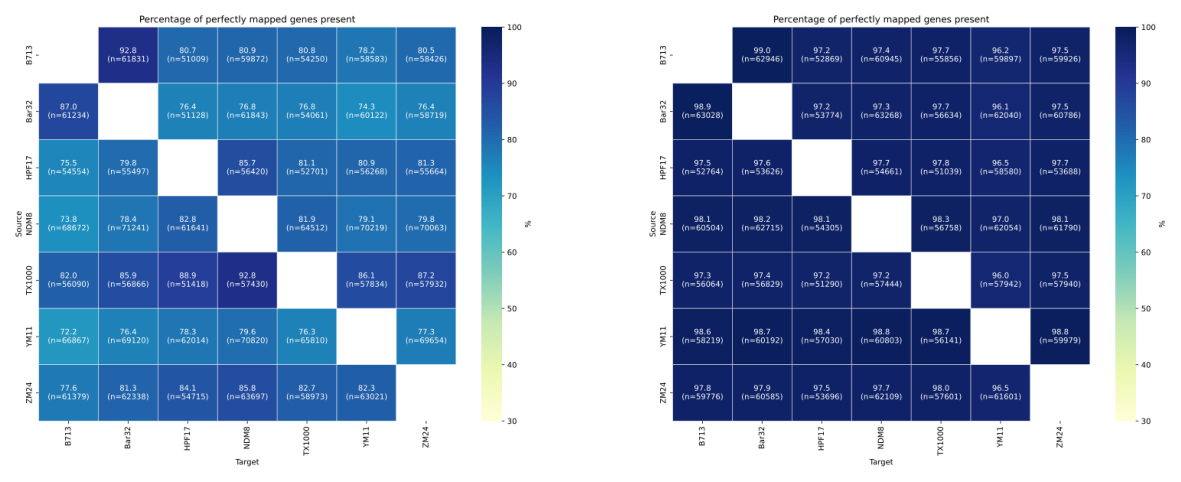

In [38]:
plt.figure(figsize=(15, 6))
plt.subplot(121); plt.imshow(plt.imread(io.BytesIO(fitz.open("consistency/external/gene_presence_1.0.pdf")[0].get_pixmap().tobytes("png")))); plt.axis('off')
plt.subplot(122); plt.imshow(plt.imread(io.BytesIO(fitz.open("consistency/jgi/gene_presence_1.0.pdf")[0].get_pixmap().tobytes("png")))); plt.axis('off')